<h1><center> DS420 - PE4: Regression Exercises

## Goal:
Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](https://english.hhi.co.kr/) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 


## Q1: Create a Spark session and read in the dataset.

#### Import libraries

In [1]:


import findspark

findspark.init('/opt/spark')
from pyspark.sql import SparkSession



#### Create a spark session named as PE4_xxx, where xxx is your last name

In [2]:
spark = SparkSession.builder.appName('PE4_MLlib_Linear_moynihanl').getOrCreate()


#### Create a DataFrame with the dataset, url to the data is given.

In [3]:
from pyspark import SparkFiles

url = 'https://raw.githubusercontent.com/BlueJayADAL/DS420/master/datasets/mllib/cruise.csv'


In [4]:
spark.sparkContext.addFile(url)



In [44]:
fileloc = SparkFiles.get('cruise.csv')
fileloc

'/tmp/spark-e5b9c084-71d1-4bae-99c0-264a70967ecc/userFiles-b5eb58dd-9224-4bed-aaa3-05fc80bbb09a/cruise.csv'

In [45]:
df = spark.read.csv('file://'+fileloc, inferSchema=True, header=True)

## Q2: Show the schema, the first 20 rows, and the basic statistics of the DataFrame.

In [46]:
df.printSchema()


root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [47]:

df.show()


+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [48]:
df.describe().show()



+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|      NaN|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

## Q3: Data transformation

#### `Ship_name` is a useless arbitrary string, but the `Cruise_line` itself may be useful. Let's make it into a categorical variable! First, find the total count for each type of cruise line.

In [49]:
df.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



#### Then, transform the `Cruise_line` column into a new numeric column named `Cruise_index`

In [50]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'Cruise_line', outputCol = 'Cruise_index')
indexed = indexer.fit(df).transform(df)

indexed.head(5)

[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Cruise_index=16.0),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Cruise_index=16.0),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, Cruise_index=1.0),
 Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, Cruise_index=1.0),
 Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, Cruise_index=1.0)]

In [51]:
indexed.groupBy('Cruise_index').count().show()

+------------+-----+
|Cruise_index|count|
+------------+-----+
|         8.0|    6|
|         0.0|   23|
|         7.0|    8|
|        18.0|    2|
|         1.0|   22|
|         4.0|   13|
|        11.0|    4|
|        14.0|    3|
|         3.0|   14|
|        19.0|    1|
|         2.0|   17|
|        17.0|    2|
|        10.0|    5|
|        13.0|    3|
|         6.0|   10|
|         5.0|   11|
|        15.0|    3|
|         9.0|    6|
|        16.0|    2|
|        12.0|    3|
+------------+-----+



#### Finally, since we don't want to preserve the order of the cruise lines, we need to do one more step which is to OneHot encode the `Cruise_index` column. Note that the `OneHotEncoder` can only work with numeric columns, therefore using StringIndexer before using OneHotEncoder is necessary. Ensure you eliminate multilinearity by setting `dropLast=True`.

In [53]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="Cruise_index",
                        outputCol="Cruise_onehot",dropLast=True)


df_numeric = encoder.fit(indexed).transform(indexed)

df_numeric.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+---------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_index|  Cruise_onehot|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+---------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|(19,[16],[1.0])|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|(19,[16],[1.0])|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0| (19,[1],[1.0])|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|         1.0| (19,[1],[1.0])|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|         1.0| (19,[1],

#### Notice 
Note above the spark one hot encoder takes the indexed label/category from the string indexer and then encodes it into a sparse vector. This is slightly different from the usual dummy column creation style. The sparse vector seen in the above dataframe has 3 different components. The first component talks about the size of the vector. The second component talks about the indices where the vector is populated while the third component talks about what values these are. This truncates the vector and is really efficient when you have really large vector representations. If you want to see the dense vector representation for this, its very easy to use a udf to transform this ([link](https://stackoverflow.com/questions/50931269/pyspark-convert-sparse-vector-obtained-after-one-hot-encoding-into-columns)).

## Q4: EDA

#### First, convert the spark `df_numeric` DataFrame to Pandas DataFrame format with `toPandas()` function.

In [54]:
df_pd = df_numeric.toPandas()



df_pd.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,Cruise_index,Cruise_onehot
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Second, use seaborn's pairplot to show the interrelationship among all numeric columns excluding `Cruise_onehot`.

In [55]:
df_pd.columns

Index(['Ship_name', 'Cruise_line', 'Age', 'Tonnage', 'passengers', 'length',
       'cabins', 'passenger_density', 'crew', 'Cruise_index', 'Cruise_onehot'],
      dtype='object')

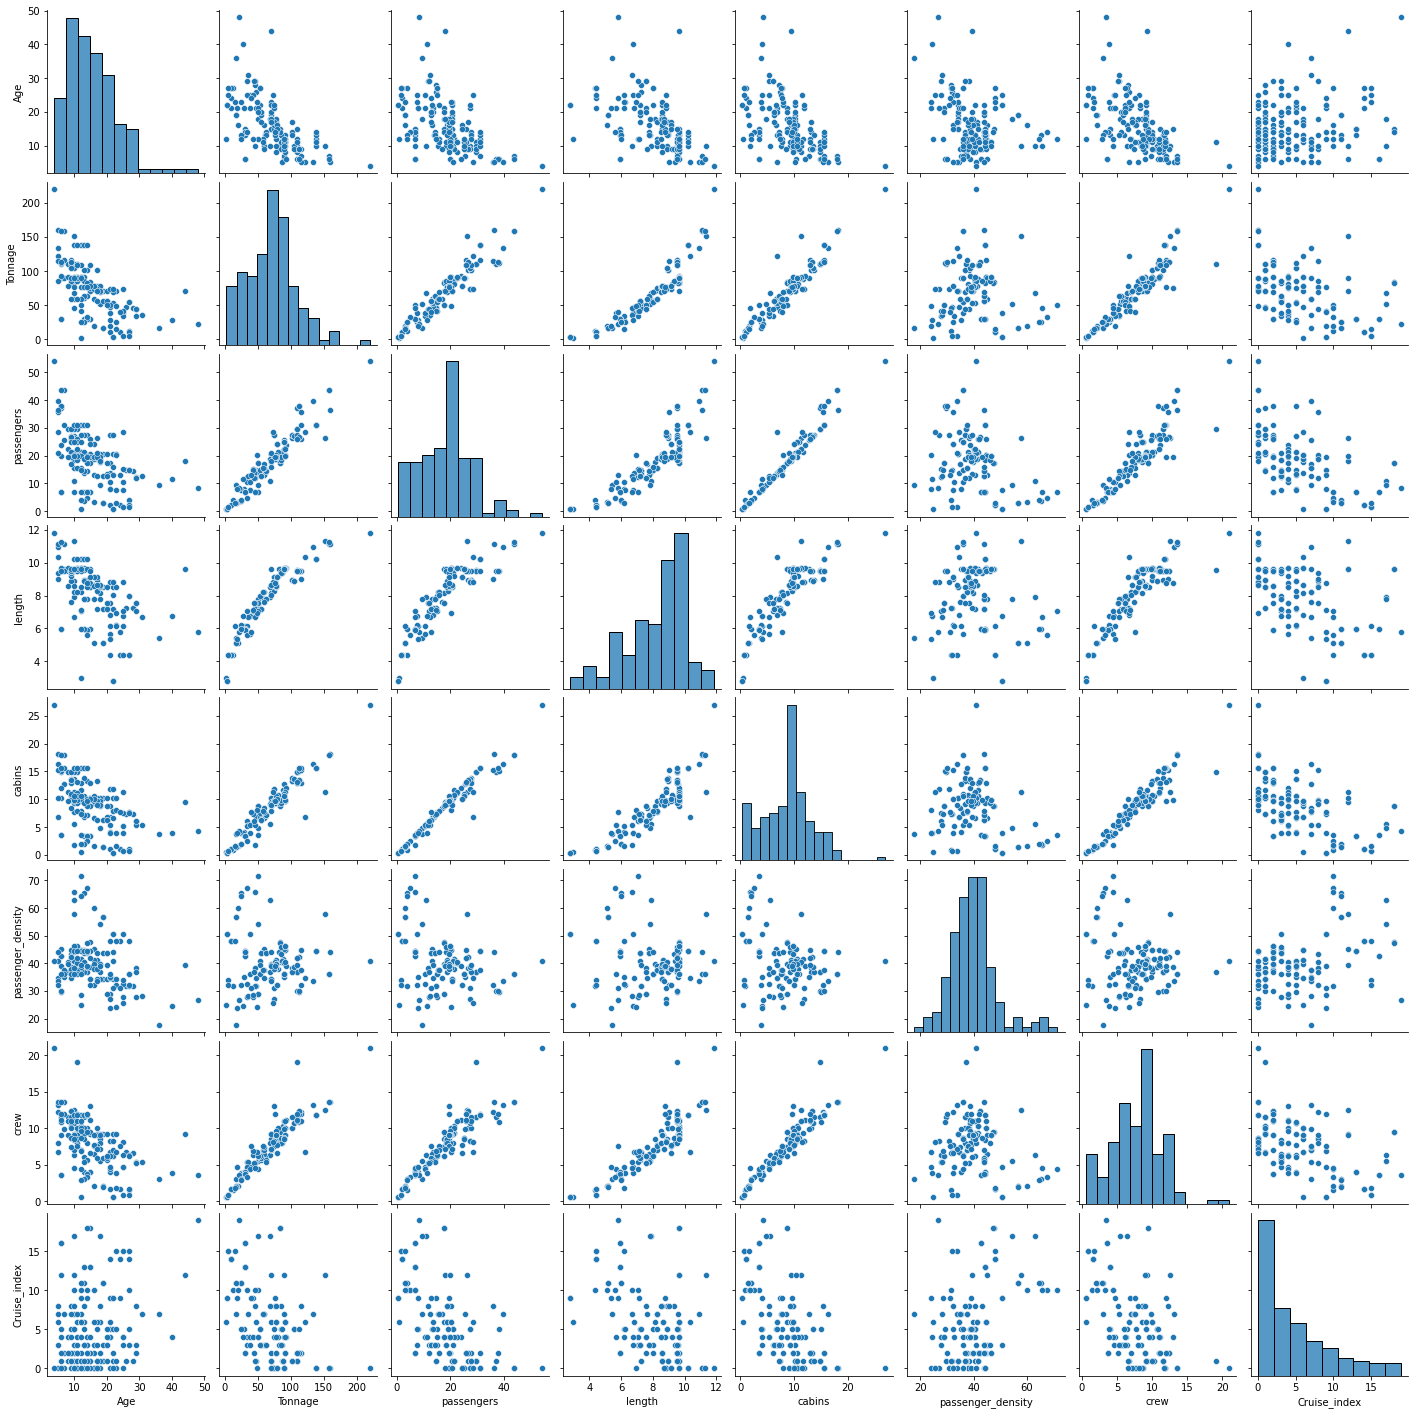

In [56]:
import seaborn as sns

sns.pairplot(df_pd[['Age', 'Tonnage', 'passengers', 'length',
       'cabins', 'passenger_density', 'crew', 'Cruise_index', 'Cruise_onehot']])



#### Lastly, checkout the distribution of the label column.

<AxesSubplot:xlabel='crew', ylabel='Count'>

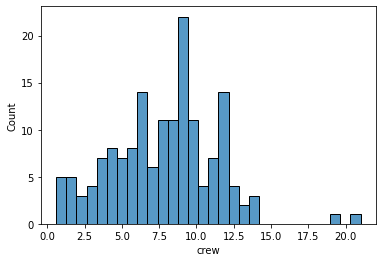

In [57]:

sns.histplot(data = df_pd['crew'], bins = 30)


## Q5: Prepare features and labels.

In [58]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#### First, check all the existing columns in `df_numeric` DataFrame.

In [59]:

df_numeric.columns


['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'Cruise_index',
 'Cruise_onehot']

#### Then, use vector assembler to combine all the numeric columns including `Cruise_onehot` into a `features` column.

In [64]:
assembler = VectorAssembler(
    inputCols=[
         'Age',
         'Tonnage',
         'passengers',
         'length',
         'cabins',
         'passenger_density',
         'Cruise_onehot'], 
    outputCol='features'
)  




In [65]:
output = assembler.transform(df_numeric)



#### Show the `features` and `crew` columns.

In [66]:
final_data = output.select(['features','crew'])



final_data.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|(25,[0,1,2,3,4,5,...|3.55|
|(25,[0,1,2,3,4,5,...|3.55|
|(25,[0,1,2,3,4,5,...| 6.7|
|(25,[0,1,2,3,4,5,...|19.1|
|(25,[0,1,2,3,4,5,...|10.0|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...|11.5|
|(25,[0,1,2,3,4,5,...|11.6|
|(25,[0,1,2,3,4,5,...| 6.6|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.3|
|(25,[0,1,2,3,4,5,...|11.6|
|(25,[0,1,2,3,4,5,...|10.3|
|(25,[0,1,2,3,4,5,...| 9.2|
|(25,[0,1,2,3,4,5,...| 9.3|
|(25,[0,1,2,3,4,5,...| 9.2|
+--------------------+----+
only showing top 20 rows



## Q6: Split the DataFrame into `train_data` and `test_data`, and use `train_data` to train a Linear Regression model.

#### Train test split.  Training = 70%, seed = 101

In [67]:
train_data, test_data = final_data.randomSplit([0.7,0.3], seed = 101)



#### Create LR model.

In [68]:
from pyspark.ml.regression import LinearRegression

# Create a Linear Regression Model object
lr = LinearRegression(featuresCol = 'features',labelCol='crew')



#### Train LR model.

In [69]:
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)



## Q7: Evaluation

#### Print the coefficients and intercept of the model.

In [70]:
# Print the coefficients and intercept for linear regression

lrModel.coefficients


DenseVector([0.0042, 0.0079, -0.1068, 0.4834, 0.7961, 0.0054, -0.8476, 0.5093, 0.4067, -0.0679, 0.6823, -0.0546, 0.9023, 0.1263, 0.4763, 1.2197, 0.5464, 0.542, -0.059, 0.9131, 0.7424, 0.1311, 0.0, 0.5539, 1.0305])

In [71]:
lrModel.intercept


-2.314204275024188

#### Evaluate the model with RMSE, MSE, and R2 scores.

In [72]:
test_results = lrModel.evaluate(test_data)





In [73]:
test_results.rootMeanSquaredError

0.6649066995822646

In [74]:
test_results.meanSquaredError

0.4421009191493798

In [75]:
test_results.r2

0.9491156817466578

#### R2 of 0.93 is pretty good, let's check the data a little closer. Checkout the correlation between `crew` and `passengers` columns.

In [77]:
import pyspark.sql.functions as F

In [78]:
df.select(F.corr('crew','passengers')).show()



+----------------------+
|corr(crew, passengers)|
+----------------------+
|    0.9152341306065384|
+----------------------+



#### Checkout the correlation between `crew` and `cabins` columns.

In [79]:
df.select(F.corr('crew','cabins')).show()





+------------------+
|corr(crew, cabins)|
+------------------+
|0.9508226063578497|
+------------------+



### Q8: Try to build a build LR model with higher degrees (degree = 2)

#### Use `PolynomialExpansion()` transformation to retrain our linear regressoion model and compare the evalution results.

In [80]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.linalg import Vectors


In [82]:


polyExpansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="polyFeatures")
train_poly = polyExpansion.transform(train_data).select(["polyFeatures","crew"])
test_poly = polyExpansion.transform(test_data).select(["polyFeatures","crew"])

In [84]:
lr2 = LinearRegression(featuresCol = "polyFeatures", labelCol = "crew")

lrModel2 = lr2.fit(train_poly)

test_result2 = lrModel2.evaluate(test_poly)




print('RMSE: ', test_result2.rootMeanSquaredError)
print('MSE: ', test_result2.meanSquaredError)
print('R2: ', test_result2.r2)







RMSE:  0.89036119588675
MSE:  0.7927430591408836
R2:  0.9087579591735184


Looks like with degree = 2, our model is even worse. This makes sense because the features do look linear to the label column. Well this is the information we can bring to the company! Your next step would be share your bank account and your first consulting paycheck would be received! Hooray!


# Great Job!